In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from category_encoders import OneHotEncoder, MEstimateEncoder, CatBoostEncoder
from sklearn import set_config
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix, log_loss
import warnings

import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)
plt.style.use('ggplot')

<center>
  
<img width=500px; src="https://images.unsplash.com/photo-1526628953301-3e589a6a8b74?q=80&w=1706&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"/>
    
<h1>German Credit Risk: A VotingClassifier Approach</h1>
    
</center>


In the realm of finance, assessing the risk of extending credit is a pivotal task that can significantly impact a lender's bottom line. The objective of this project is to harness the power of machine learning to develop a classifier that predicts the risk associated with granting credit to potential borrowers. By analyzing a rich dataset of German credit risk data, this classifier aims to evaluate applicants based on various financial and personal aspects, enabling lenders to make informed, data-driven decisions. Through this endeavor, we seek to create a model that is not only accurate but also interpretable, providing clear insights into the factors influencing credit risk assessment.

```python
if happy:
    print('Please Upvote 🔝')
```

**Data Description**

- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (numeric, in DM - Deutsch Mark)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others
- Risk (Value target - Good or Bad Risk)

# <span style='color:#0d9dd6;'>|</span> Table of Content

- [Setup](#setup)
- [EDA (Exploratory of Data Analysis)](#eda)
    - [Univariate Analysis](#univariate_analysis)
        - [Target Distribution](#target_distribution)
        - [Numerical Data](#numerical_data)
        - [Categorical Data](#categorical_data)
    - [Bivariate Analysis](#bivariate_analysis)
        - [Pairplot](#pairplot)
        - [Numerical feature distribution by Risk](#numerical_feature_distribution_by_risk)
        - [Categorical feature distribution by Risk](#categorical_feature_distributon_by_risk)
        - [Credit amount and age](#credit_amount_and_age)
        - [Credit amount and duration](#credit_amount_and_duration)
        - [Correlation matrix](#correlation_matrix)
- [Preprocessing](#preprocessing)
- [Modeling and Cross Validation](#modeling_and_cross_validation)
- [Voting](#voting)
- [Final Model](#final_model)
- [Prediction on evaluation set](#prediction_on_evaluation_set)

<a id='setup'></a>
# <span style='color:#0d9dd6;'>|</span> Setup

In [2]:
data = pd.read_csv('/kaggle/input/german-credit-data-with-risk/german_credit_data.csv', index_col=[0])
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
print(data.shape)

(1000, 10)


In total we have 1000 observations with 10 columns ( 9 features + target)

In [4]:
data.describe().style.background_gradient('Blues')

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


Descriptive statistics can only applied on 4 numerical columns. Let´s check the datatypes and if they have missing values. 

In [5]:
table = PrettyTable()

table.field_names = ['Feature', 'Data Type', 'Missing Values', 'Missing %']
for column in data.columns:
    data_type = str(data[column].dtype)
    null_cnt = data[column].isna().sum()
    null_prc= np.round(null_cnt/data.shape[0]*100,1)
    table.add_row([column, data_type, null_cnt, null_prc])
print(table)

+------------------+-----------+----------------+-----------+
|     Feature      | Data Type | Missing Values | Missing % |
+------------------+-----------+----------------+-----------+
|       Age        |   int64   |       0        |    0.0    |
|       Sex        |   object  |       0        |    0.0    |
|       Job        |   int64   |       0        |    0.0    |
|     Housing      |   object  |       0        |    0.0    |
| Saving accounts  |   object  |      183       |    18.3   |
| Checking account |   object  |      394       |    39.4   |
|  Credit amount   |   int64   |       0        |    0.0    |
|     Duration     |   int64   |       0        |    0.0    |
|     Purpose      |   object  |       0        |    0.0    |
|       Risk       |   object  |       0        |    0.0    |
+------------------+-----------+----------------+-----------+


Too bad. We have a lot of missing values in the columns `Saving accounts` and `Checking account`. Both variables are objects. So let´s just replace the null values with a default valued called `unknown`. 

In [6]:
data = data.fillna('unknown')

In [7]:
data.isnull().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

Good, now we have no missing values. Before we go into the next section, I will change the datatypes from object to categorical features. 

In [8]:
# Convert object types to category
object_cols = data.select_dtypes(include=['object']).columns
data[object_cols] = data[object_cols].astype('category')

In [9]:
# We also want to convert job to category because it has only 4 distinct values
data['Job'] = data['Job'].astype('category')

In [10]:
# Create helper array with numerical and categorical column names
num_features = data._get_numeric_data().columns.tolist()
cat_features = data.drop(num_features, axis=1).columns.tolist()

In [11]:
print(f'Numerical columns: {num_features}')
print(f'Categorical columns: {cat_features}')

Numerical columns: ['Age', 'Credit amount', 'Duration']
Categorical columns: ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']


<a id='eda'></a>
# <span style='color:#0d9dd6;'>|</span> EDA (Exploratory of Data Analysis)
<a id='univariate_analysis'></a>
## <span style='color:#0d9dd6;'>|</span> Univariate Analysis
<a id='target_distribution'></a>
### <span style='color:#0d9dd6;'>|</span> Target Distribution

Let´s start with our target and show how it´s distributed. 

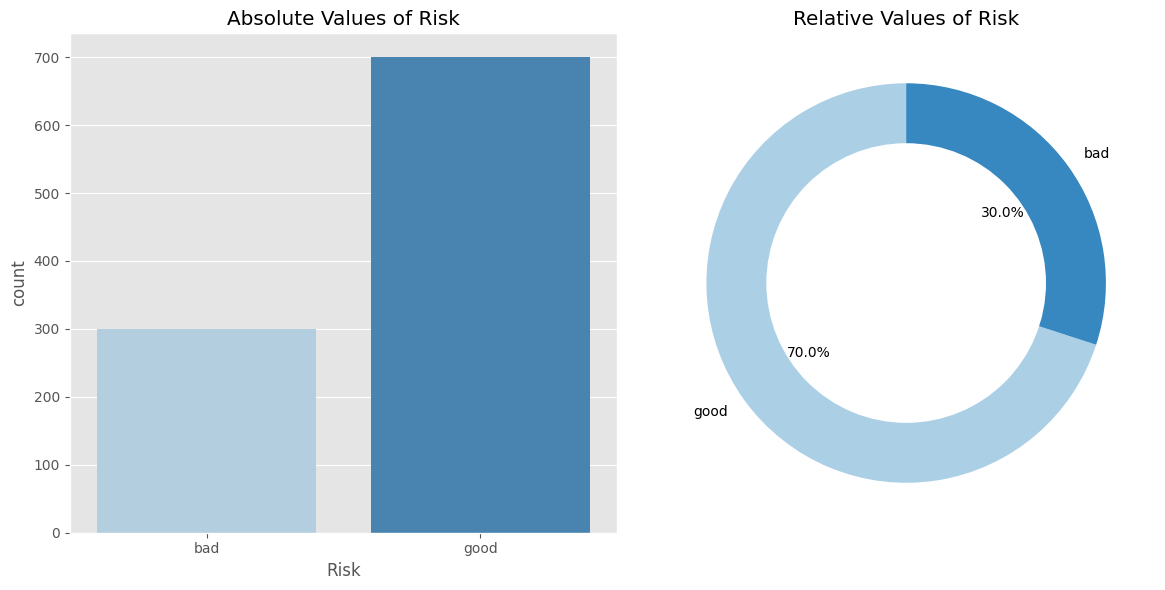

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(x='Risk', data=data, ax=ax[0], palette='Blues')
ax[0].set_title('Absolute Values of Risk')
colors = sns.color_palette('Blues', n_colors=data['Risk'].nunique())
risk_counts = data['Risk'].value_counts()
ax[1].pie(risk_counts, labels=risk_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
ax[1].add_artist(plt.Circle((0,0),0.70,fc='white'))
ax[1].set_title('Relative Values of Risk')
plt.tight_layout()
plt.show();

We face the imbalanced classification problem here. An imbalanced classification problem is an example of a classification problem where the distribution of examples across the known classes is biased or skewed. The distribution can vary from a slight bias to a severe imbalance where there is one example in the minority class for hundreds, thousands, or millions of examples in the majority class or classes, in our case 70/30.

Imbalanced classifications pose a challenge for predictive modeling as most of the machine learning algorithms used for classification were designed around the assumption of an equal number of examples for each class. This results in models that have poor predictive performance, specifically for the minority class. This is a problem because typically, the minority class is more important and therefore the problem is more sensitive to classification errors for the minority class than the majority class.

We could use over- or undersampling methods to make the distribution more equal. However, in order not to make the notebook unnecessarily complicated and long, we will dispense with it here and use the imbalanced dataset for training a model. 

<a id='numerical_data'></a>
### <span style='color:#0d9dd6;'>|</span> Numerical Data

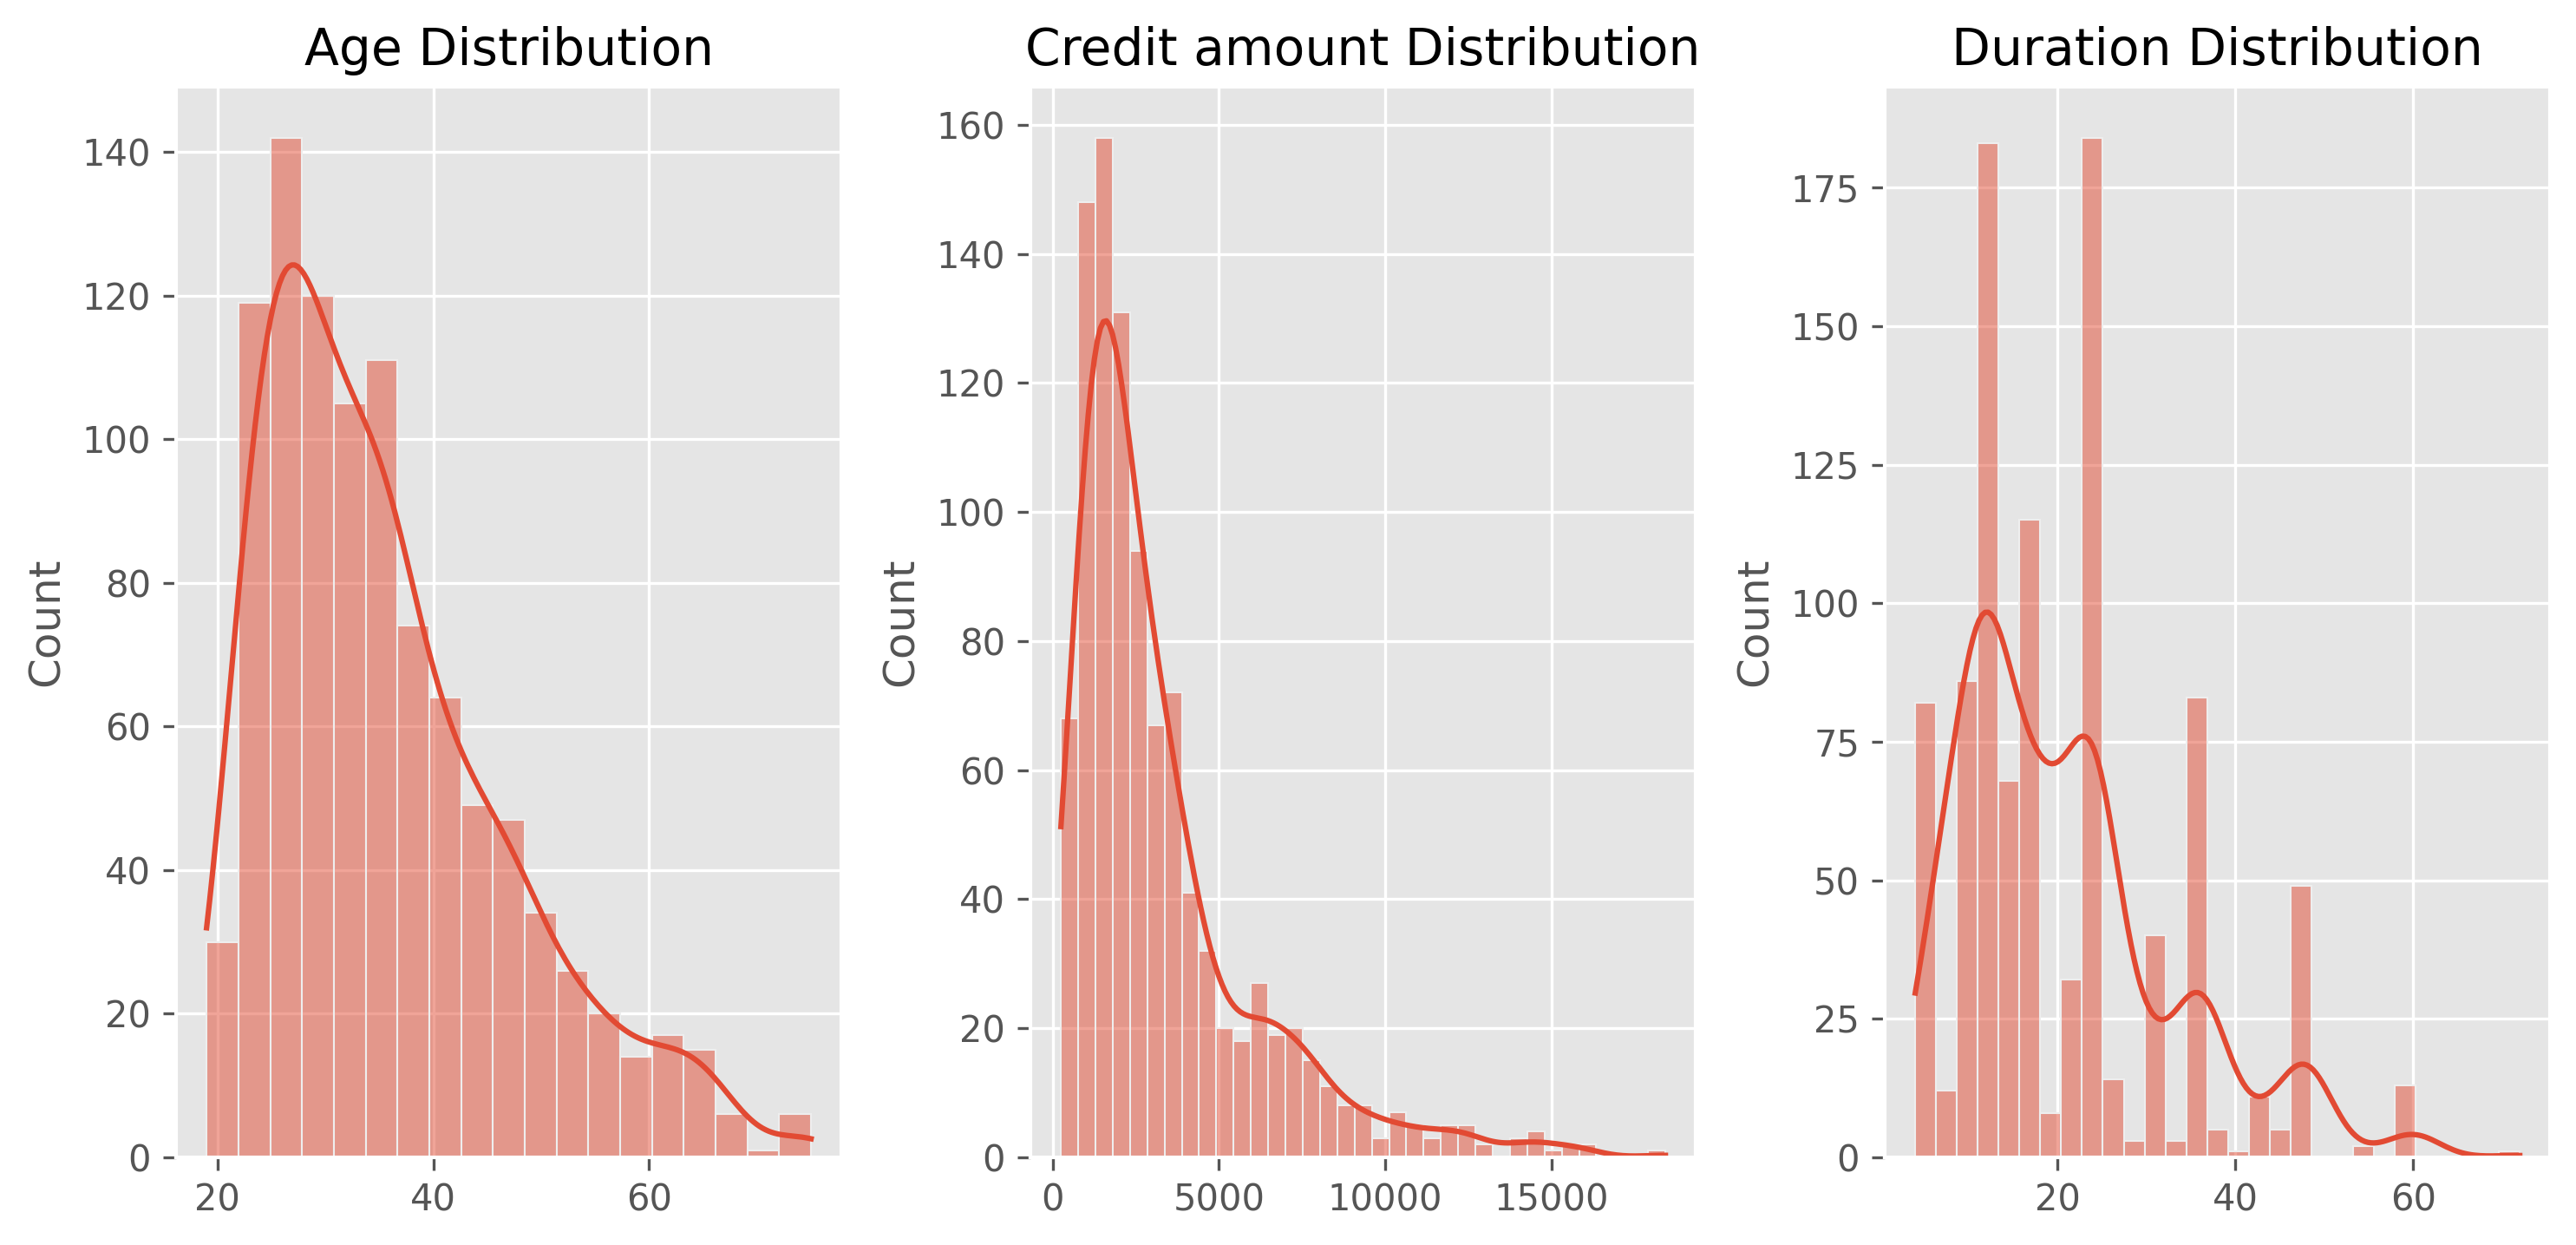

In [13]:
fig, ax = plt.subplots(1, 3, figsize = (10, 5), dpi=300)
ax = ax.flatten()
for idx,column in enumerate(num_features):
    sns.histplot(data=data, x=column, ax=ax[idx], palette='blues', kde=True)
    ax[idx].set_title(f'{column} Distribution', size = 14)
    ax[idx].set_xlabel(None)
    plt.tight_layout()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show();

fig.suptitle('Distribution of Numeric Features', fontsize=16, fontweight='bold')
fig.savefig('/kaggle/working/distribution_of_numeric_features.png', bbox_inches='tight')


The age and amount of credit are strongly distributed to the right. This is relatively easy to explain. Younger people are more likely to need a loan because they have not been able to save as much as older people. In addition, the majority of people do not need a loan of several tens of thousands of dollars. 

Theoretically, you could apply transformations to the data sets to make them more normally distributed. However, since we will mainly be working with tree-based models later on, this is not necessary. 


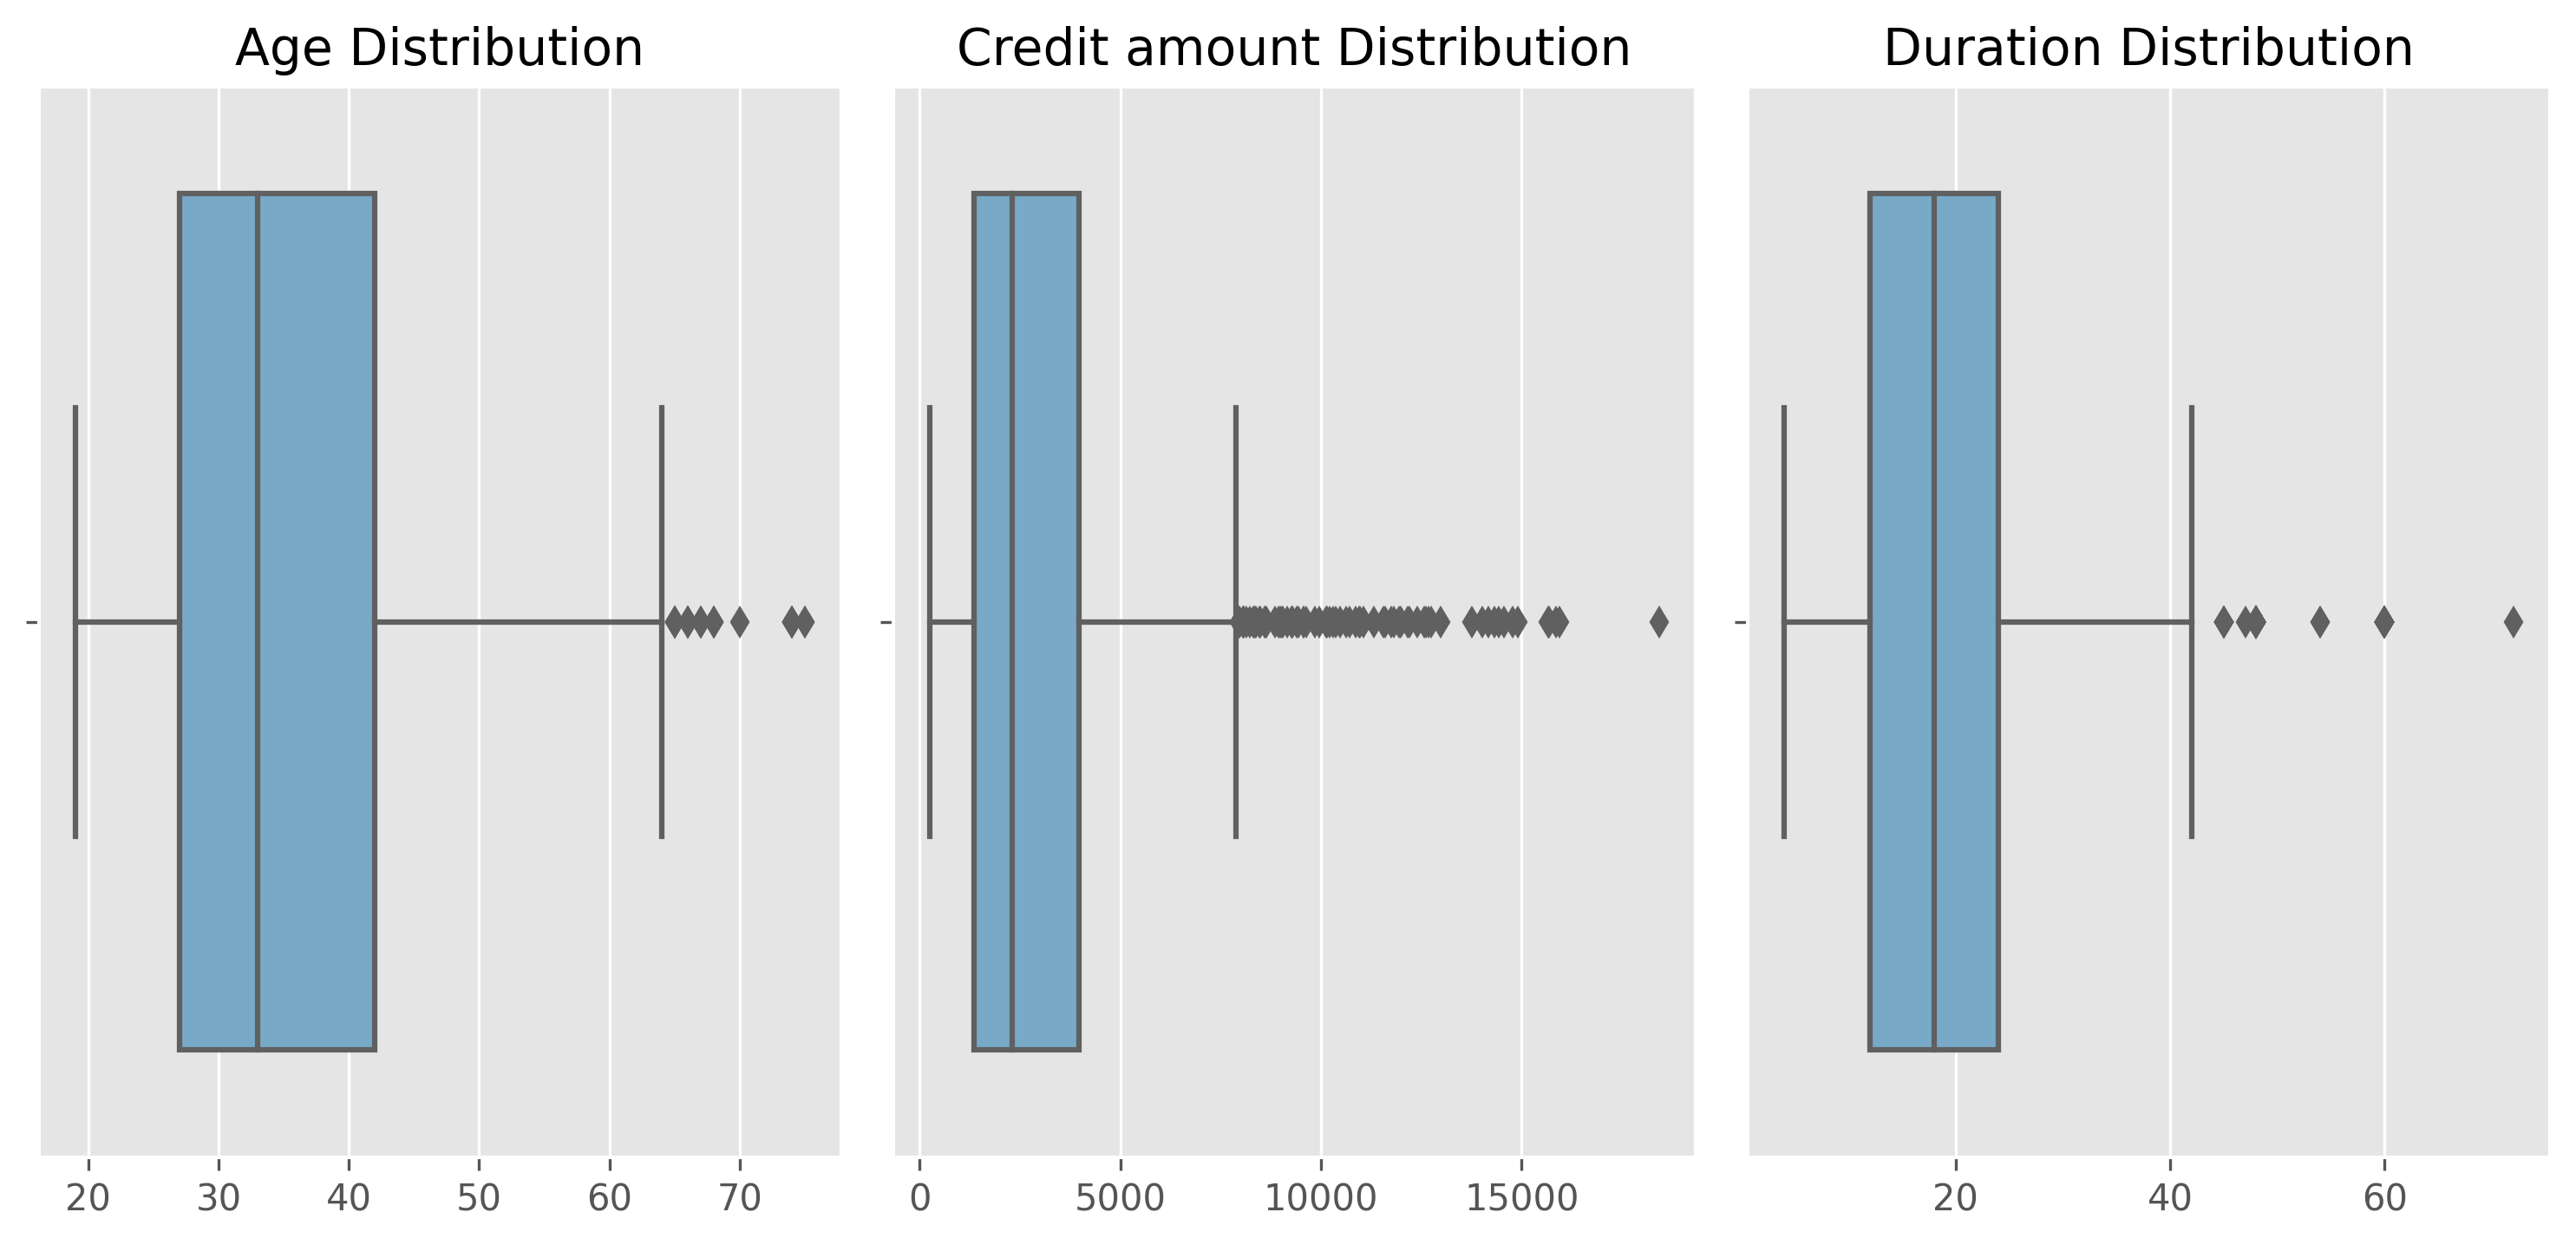

In [14]:
fig, ax = plt.subplots(1, 3, figsize = (10, 5), dpi=300)
ax = ax.flatten()
for idx,column in enumerate(num_features):
    sns.boxplot(data=data, x=column, ax=ax[idx], palette='Blues')
    ax[idx].set_title(f'{column} Distribution', size = 14)
    ax[idx].set_xlabel(None)
    plt.tight_layout()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show();

There are also some outliers in this data set. As with the distribution of the data, these can be ignored here as most tree-based algorithms are robust against outliers. 

<a id='categorical_data'></a>
### <span style='color:#0d9dd6;'>|</span> Categorical Data

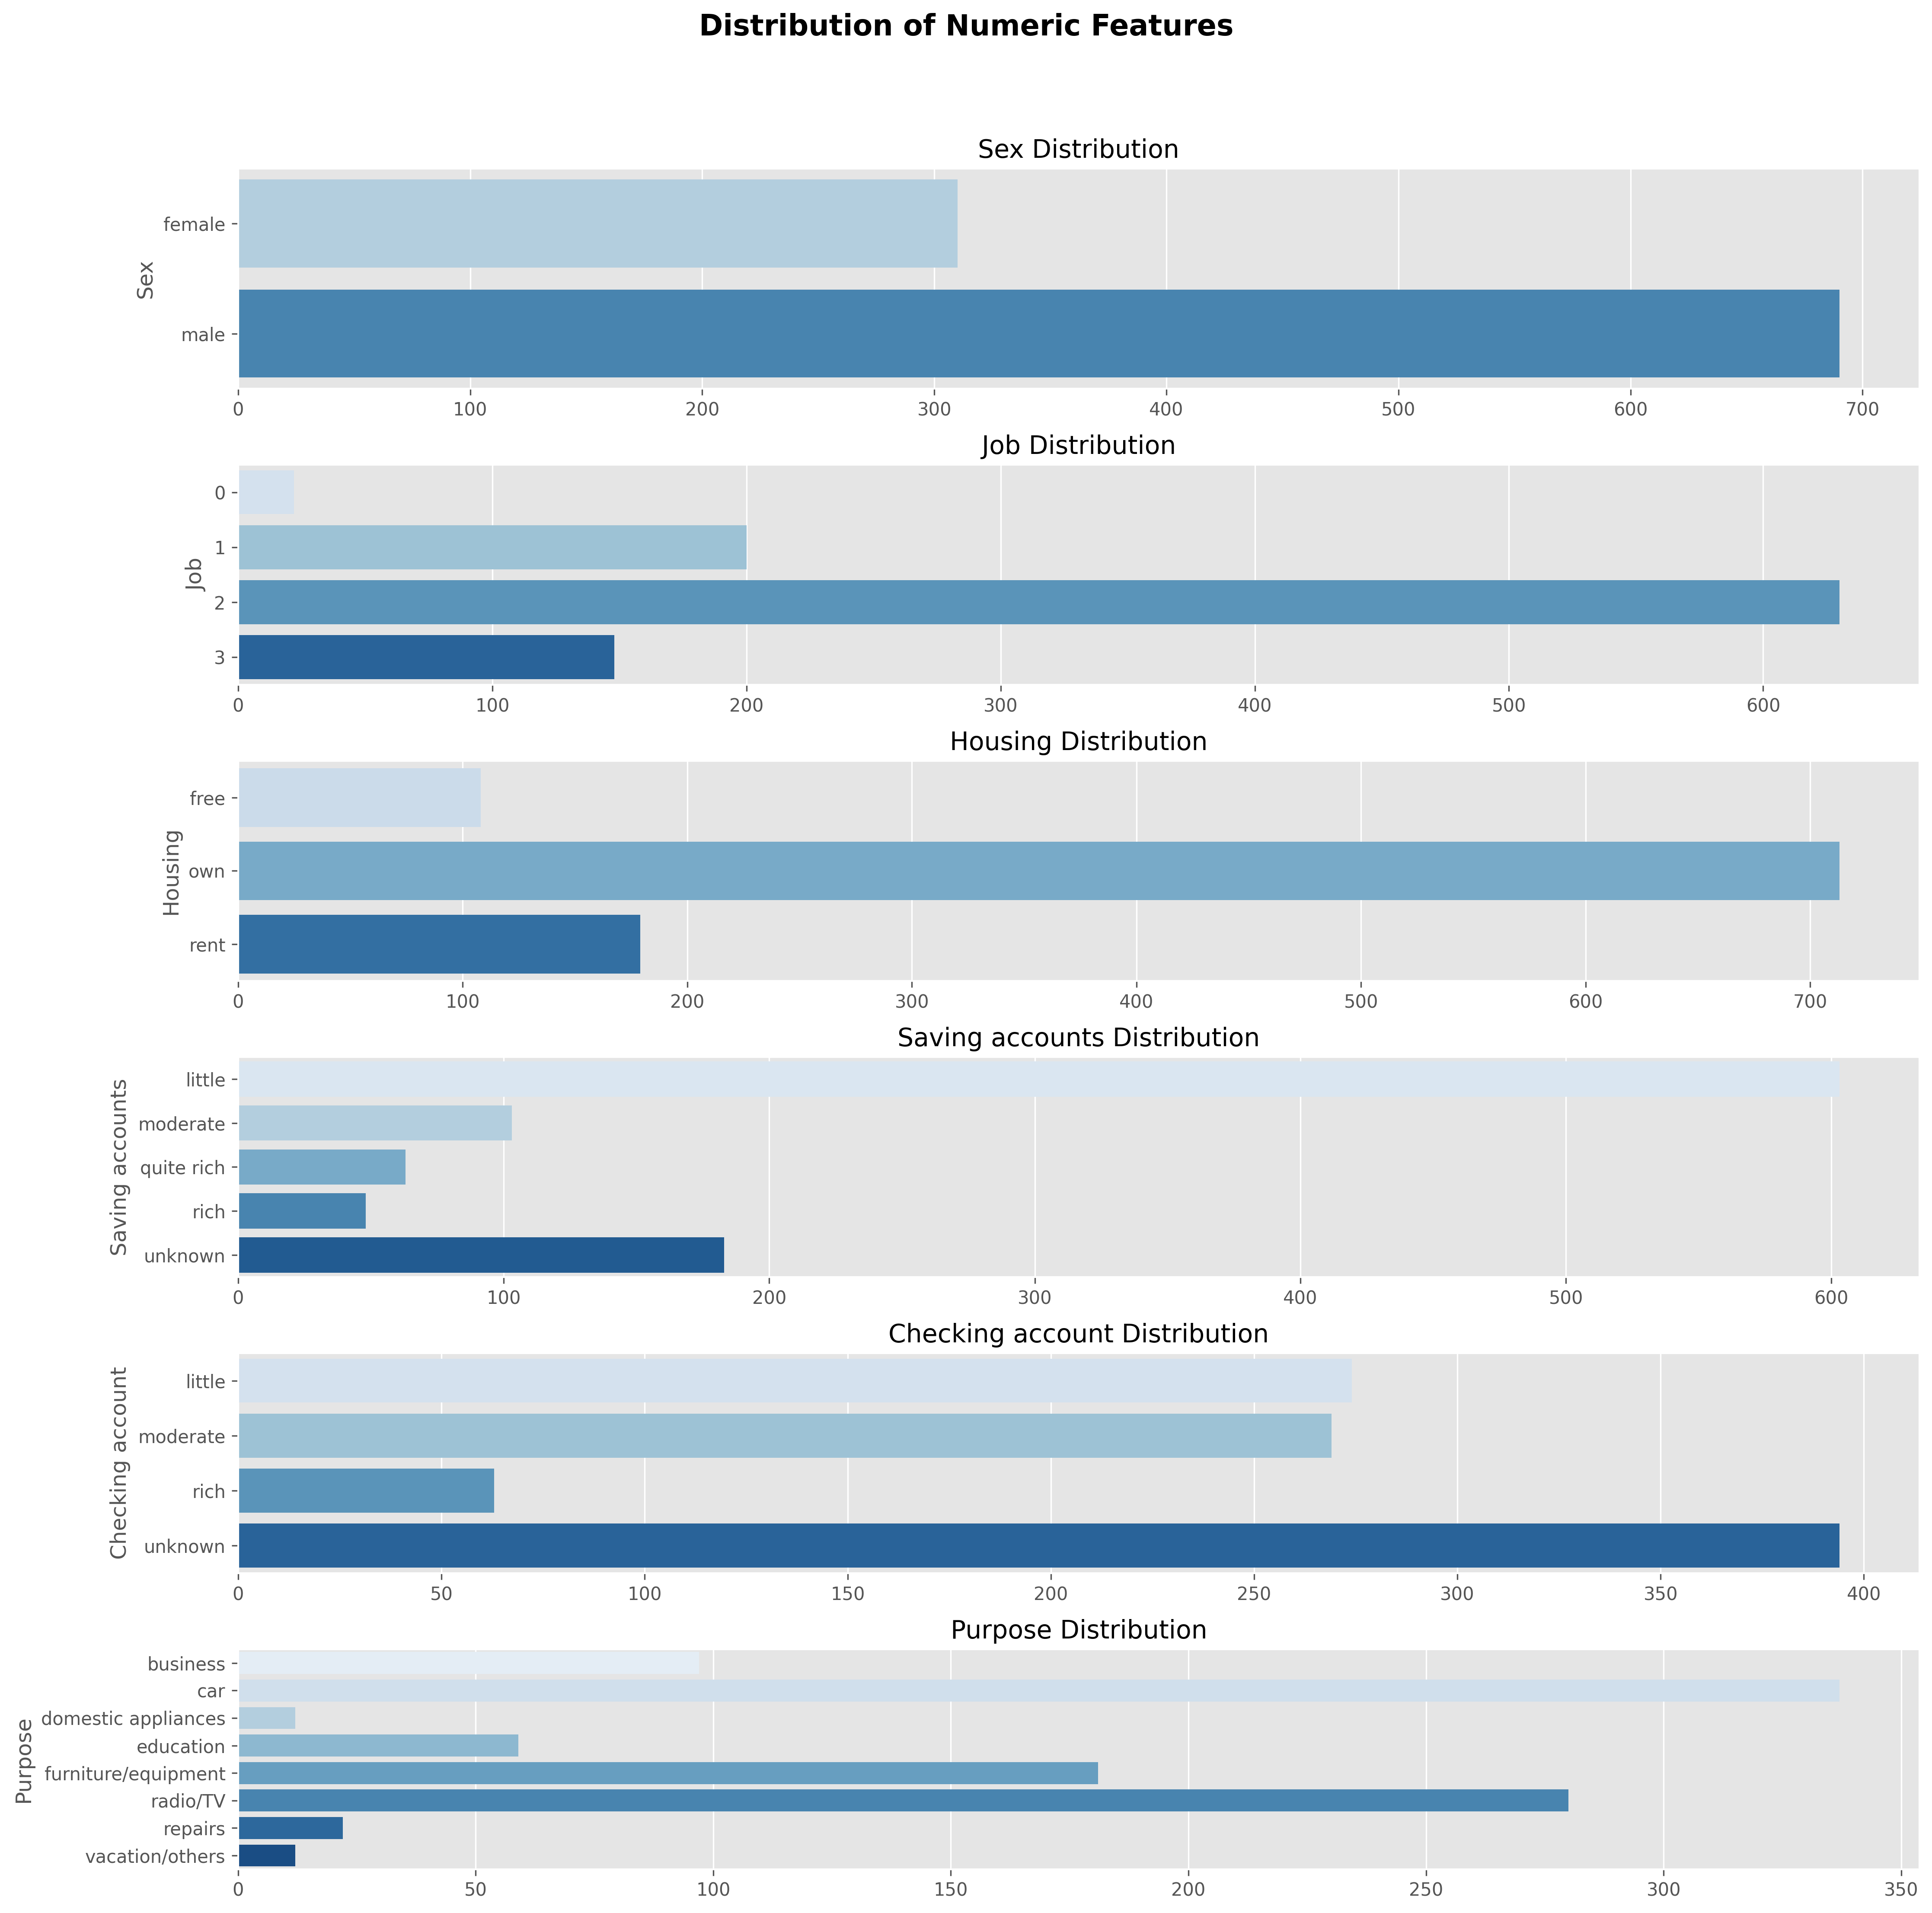

In [15]:
plt.style.use('ggplot')
fig, ax = plt.subplots(6, 1, figsize = (15, 15), dpi=300)
ax = ax.flatten()
# Exclude last value from cat features because this is our target and was already visualized above
for idx,column in enumerate(cat_features[:-1]):
    sns.countplot(data=data, y=column, ax=ax[idx], palette='Blues')
    ax[idx].set_title(f'{column} Distribution', size = 14)
    ax[idx].set_xlabel(None)
    plt.tight_layout()
fig.suptitle('Distribution of Numeric Features', fontsize = 16, fontweight = 'bold')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show();

Significantly more men take out a loan than women. 

People who have a profession that qualifies them as skilled are significantly more likely to take out a loan. This can probably be explained by the fact that jobs with little skill are very poorly paid. These people cannot afford a loan in the first place. It also makes sense to me that people with highly skilled jobs do not need a loan. Such people could be top managers, for example. They already earn a lot of money and therefore don't need a loan. 

What is very surprising, however, is what the loan is used for. Cars and radio/TV are in first and second place. Of course a car is expensive, but do you always have to have the best and most expensive? Exactly the same with radio and TV. Do you have to have the biggest TV or will a smaller one do? Important things like education have a rather small share in the whole thing. 

<a id='bivariate_analysis'></a>
## <span style='color:#0d9dd6;'>|</span> Bivariate Analysis

The univariate analysis gave us a quick overview about each column in it´s own. Now comes the important and interesting part where we check the variables on each others. 
<a id='pairplot'></a>
### <span style='color:#0d9dd6;'>|</span> Pairplot




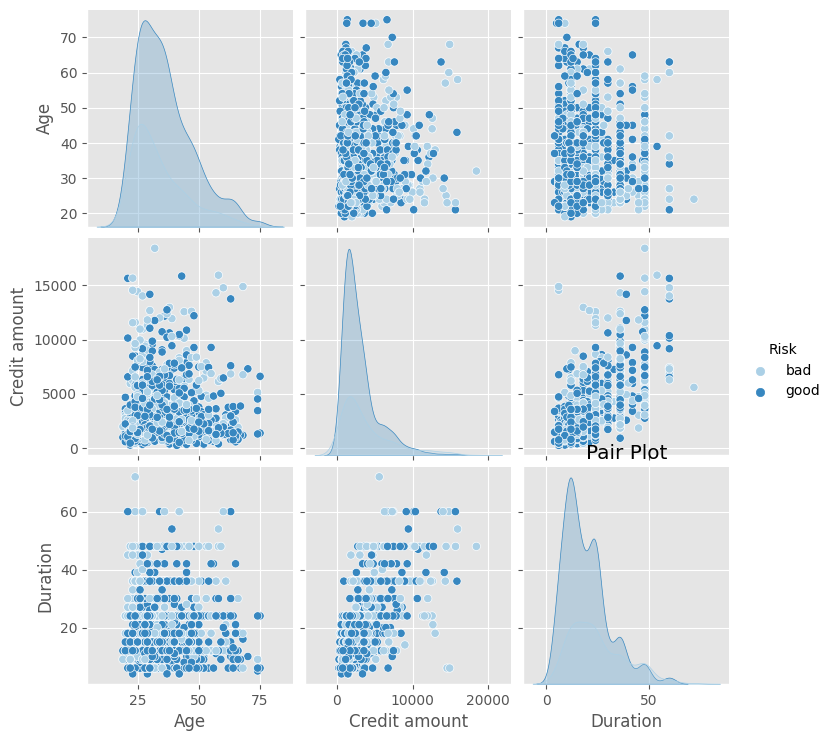

In [16]:
plt.style.use('ggplot')
sns.pairplot(data, hue='Risk', palette='Blues')
plt.title('Pair Plot')
plt.show();

<a id='numerical_feature_distrbution_by_risk'></a>
### <span style='color:#0d9dd6;'>|</span> Numerical feature distribution by Risk

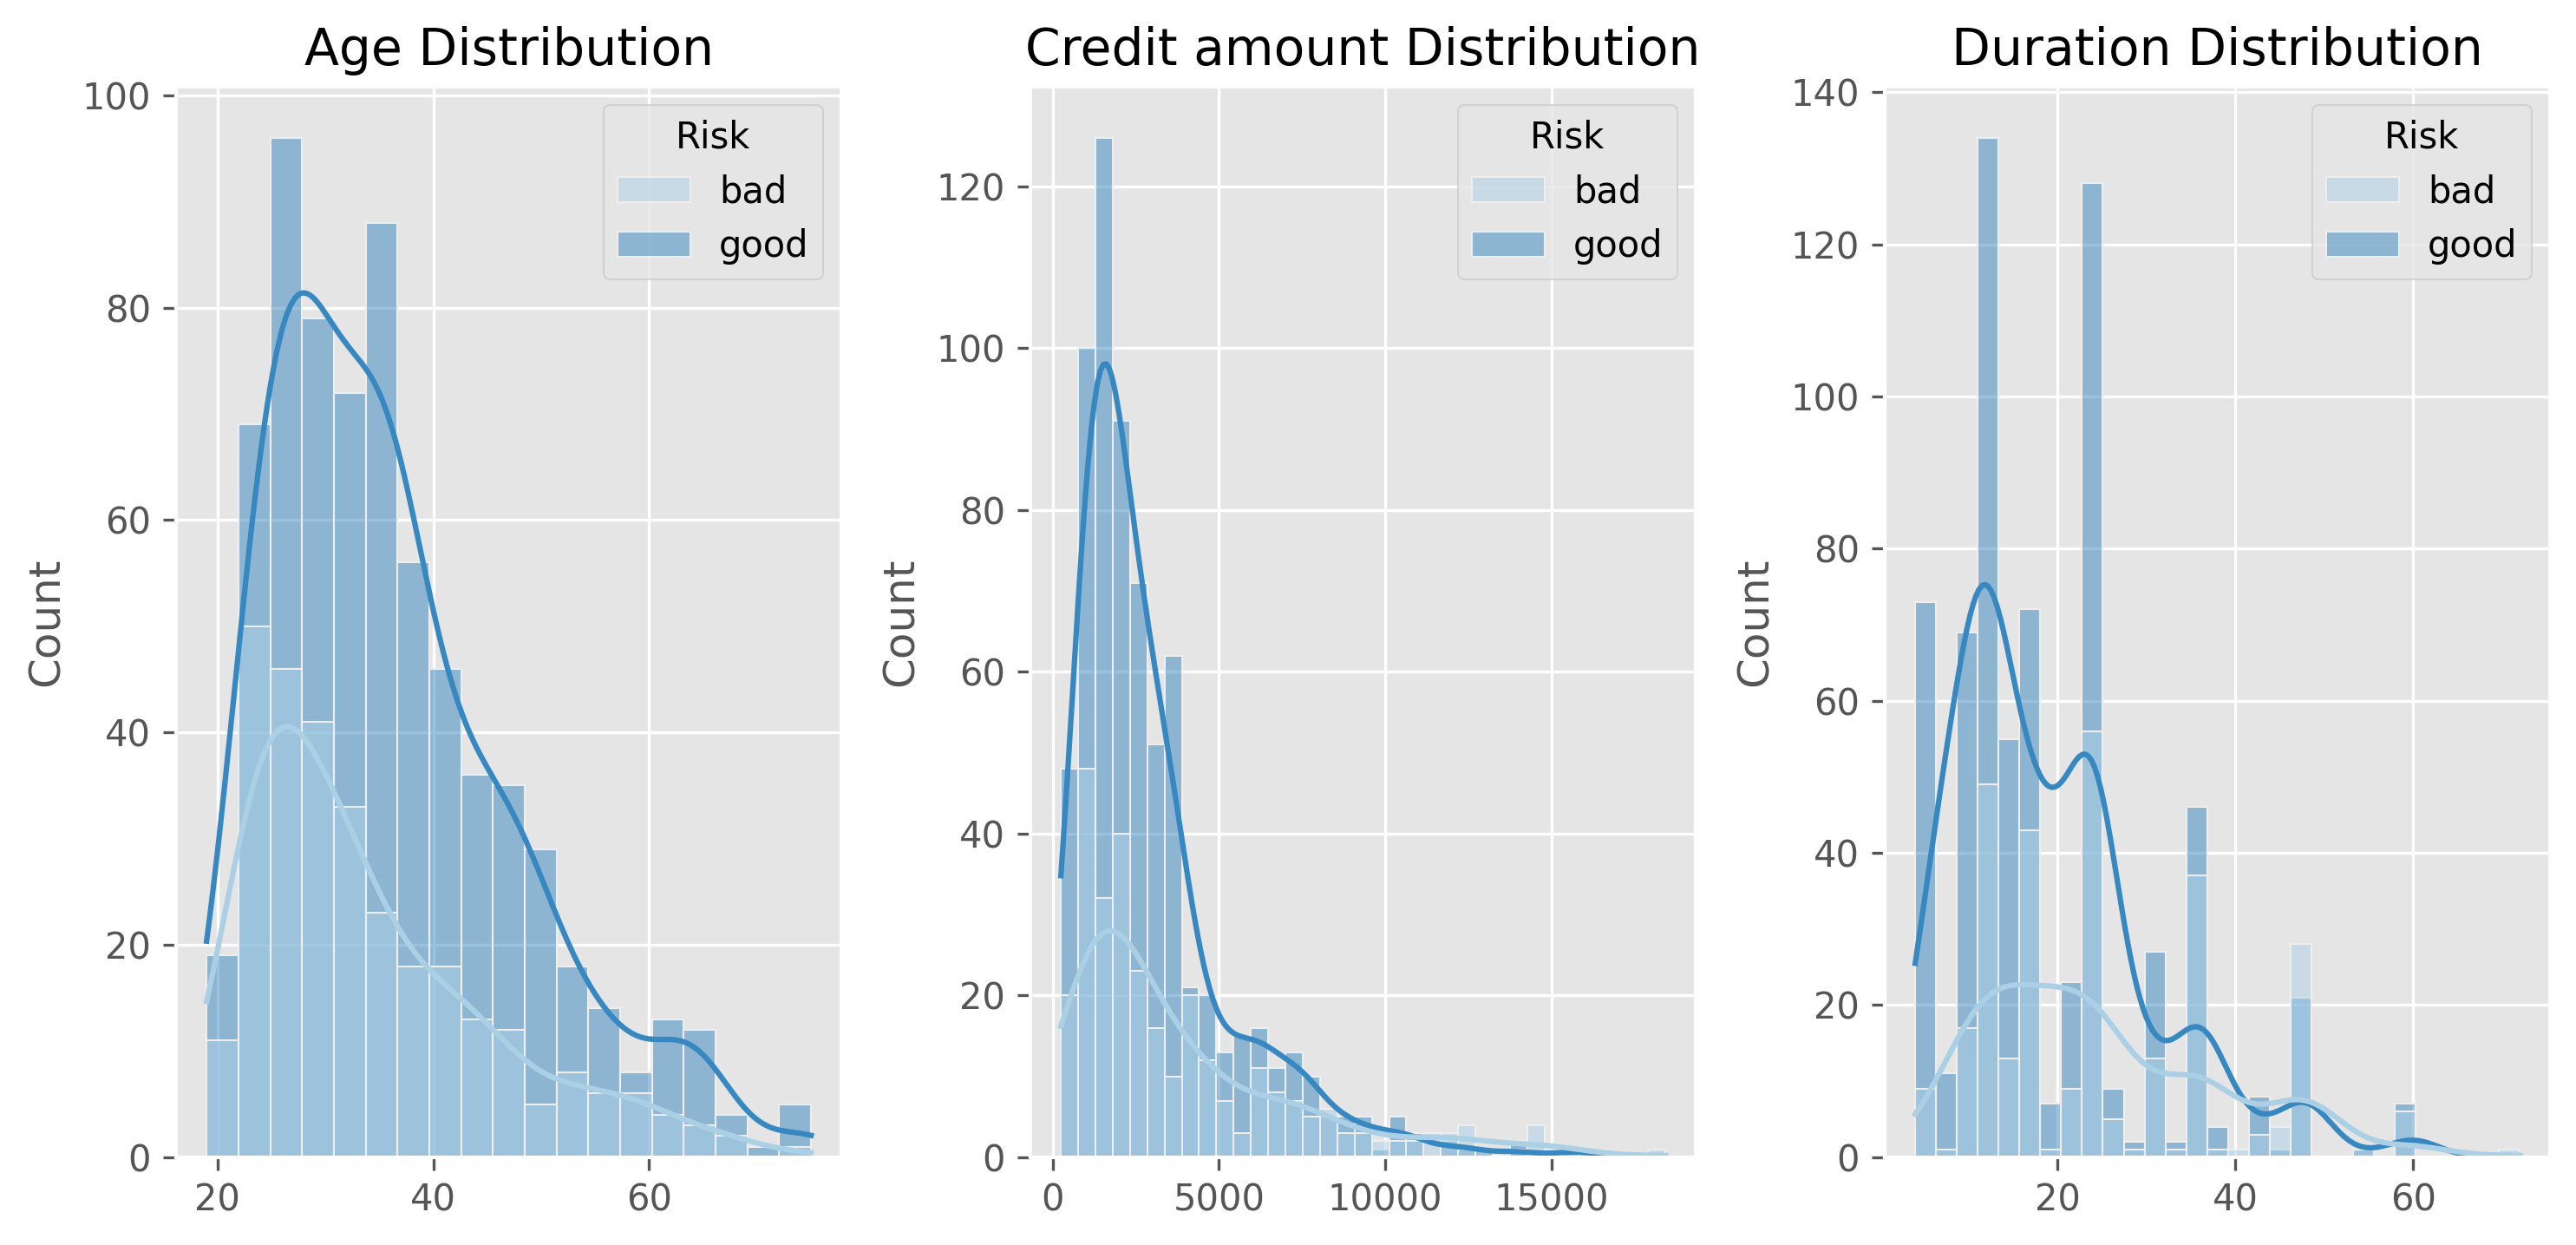

In [17]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 3,figsize = (10, 5), dpi=300)
ax = ax.flatten()
for idx,column in enumerate(num_features):
    sns.histplot(data=data, x=column, ax=ax[idx], palette='Blues', kde=True, hue='Risk')
    ax[idx].set_title(f'{column} Distribution', size = 14)
    ax[idx].set_xlabel(None)
    plt.tight_layout()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show();

From this plot, we can see some intersting insights:
- **The younger the more risk**
    - Sounds valid, older people have more financial stability than youn people
    - If you have more money, you can probably pay back the loan sooner
- **The higher the loan, the higher the risk**
    - You don't need to say much about it, it goes without saying
- **The longer the loan term, the higher the risk**
    - The longer the term of the loan, the more fees would have to be paid
    - The amount that has to be repaid increases accordingly

<a id='categorical_feature_distribution_by_risk'></a>
### <span style='color:#0d9dd6;'>|</span> Categorical feature distribution by Risk

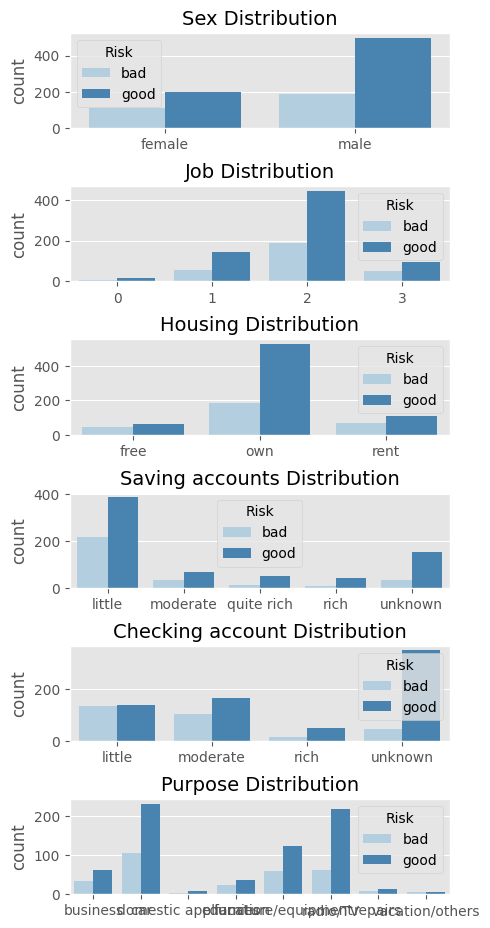

In [18]:
plt.style.use('ggplot')
fig, ax = plt.subplots(6, 1,figsize = (5, 10))
ax = ax.flatten()
for idx,column in enumerate(cat_features[:-1]):
    sns.countplot(data=data, x=column, ax=ax[idx], palette='Blues', hue='Risk')
    ax[idx].set_title(f'{column} Distribution', size = 14)
    ax[idx].set_xlabel(None)
    plt.tight_layout()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show();

<a id='credit_amount_and_age'></a>
### <span style='color:#0d9dd6;'>|</span> Credit amount and age

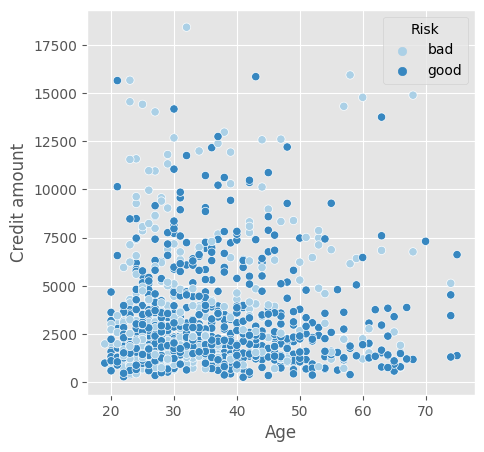

In [19]:
plt.figure(figsize=(5, 5))
plt.style.use('ggplot')

sns.scatterplot(
    y='Credit amount', 
    x='Age', 
    data=data, 
    hue='Risk', 
    palette='Blues', 
    marker='o'
)

plt.show()

**The younger and higher the loan, the greater the risk**
- Logically, we have already seen above that the younger you are, the higher the risk
- In addition, the higher the credit line, the higher the risk

<a id='credit_amount_and_duration'></a>
### <span style='color:#0d9dd6;'>|</span> Credit amount and duration

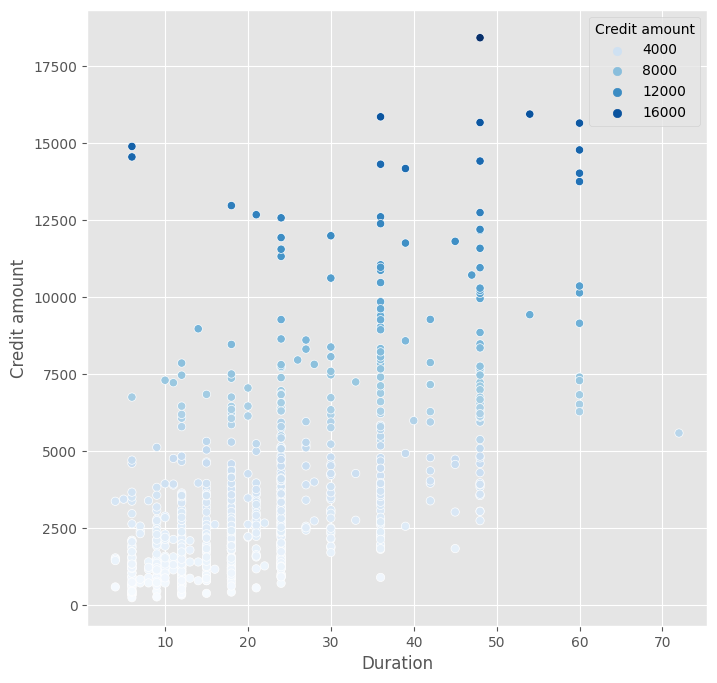

In [20]:
plt.figure(figsize=(8, 8))
plt.style.use('ggplot')

sns.scatterplot(
    y='Credit amount', 
    x='Duration', 
    data=data, 
    hue='Credit amount', 
    palette='Blues', 
    marker='o'
)

plt.show()

**The higher the loan, the longer the duration**
- Quite normal, it's a few hundred dollars can be repaid faster than a few thousand

<a id='correlation_matrix'></a>
### <span style='color:#0d9dd6;'>|</span> Correlation matrix

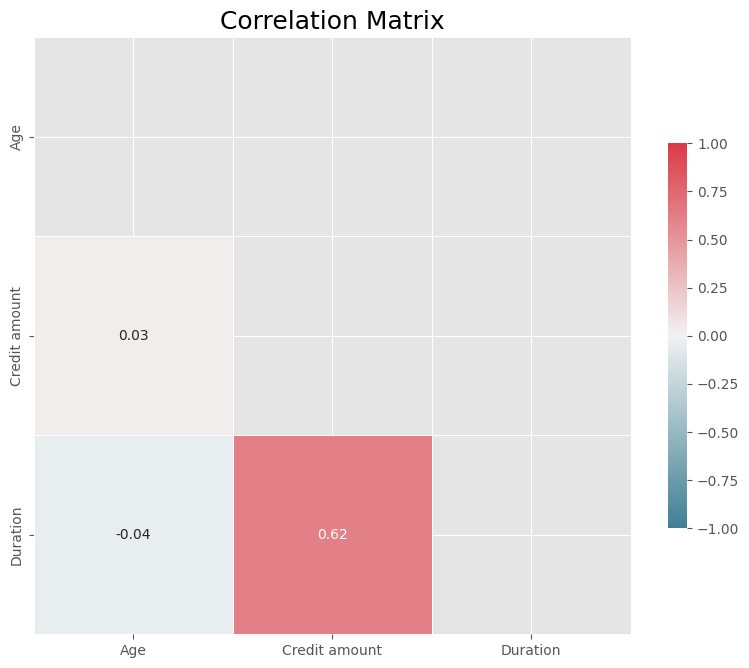

In [21]:
corr = data[num_features].corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title('Correlation Matrix', fontsize=18)
plt.tight_layout()

Not much can be read from the correlation matrix, as we only have a total of 3 numerical features that are included in the graph. 

<a id='preprocessing'></a>
# <span style='color:#0d9dd6;'>|</span> Preprocessing

Before we get started, I will encapsulate 10% of the database from the existing data set. This small data set will ultimately be used to precisely determine the performance of the model. 

In [22]:
data, evaluation_set = train_test_split(data, test_size=.1, shuffle=True, random_state=1702)

In [23]:
# Separate target from data
y = data['Risk']
X = data.drop(columns=['Risk'])

In [24]:
# One hot encode the target (Not all models can work with categorical values)
encoder = LabelEncoder().fit(y)
y = encoder.transform(y)

In [25]:
seed = 1702
np.random.seed(seed)
skf = StratifiedKFold(random_state=seed, shuffle=True)

<a id='modeling_and_cross_validation'></a>
# <span style='color:#0d9dd6;'>|</span> Modeling and Cross-Validation
Okay now train several models and evaluate their performances. 

In [26]:
def cross_validation_score(estimator, cv, label=''):
    X = data.copy()
    y = encoder.transform(X.pop('Risk'))
    X = pd.get_dummies(X)
    #val_predictions = np.zeros((len(X)))
    train_scores, val_scores = [], []
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        model = clone(estimator)
        
        X_train = X.iloc[train_idx].reset_index(drop = True)
        y_train = y[train_idx]
        X_val = X.iloc[val_idx].reset_index(drop = True)
        y_val = y[val_idx]
        
        model.fit(X_train, y_train)
        
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        
        train_score = accuracy_score(y_train, train_preds)
        val_score = accuracy_score(y_val, val_preds)
        
        train_scores.append(train_score)
        val_scores.append(val_score)
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    return val_scores

In [27]:
score_list, oof_list = pd.DataFrame(), pd.DataFrame()

models = [
    ('log', LogisticRegression(random_state = seed, max_iter = 1000000, class_weight = 'balanced')),
    ('lda', LinearDiscriminantAnalysis()),
    ('gnb', GaussianNB()),
    ('bnb', BernoulliNB()),
    ('rf', RandomForestClassifier(random_state = seed)),
    ('et', ExtraTreesClassifier(random_state = seed)),
    ('xgb', XGBClassifier(random_state = seed)),
    ('lgb', LGBMClassifier(random_state = seed, verbose=-1)),
    ('dart', LGBMClassifier(random_state = seed, boosting_type = 'dart', verbose=-1)),
    ('cb', CatBoostClassifier(random_state = seed, verbose = 0)),
    ('gb', GradientBoostingClassifier(random_state = seed)),
    ('hgb', HistGradientBoostingClassifier(random_state = seed)),
]

In [28]:
for (label, model) in models:
    score_list[label] = cross_validation_score(estimator=model,
                                                                cv=skf,
                                                                label=label)

Val Score: 0.68222 ± 0.02091 | Train Score: 0.69833 ± 0.00821 | log
Val Score: 0.72111 ± 0.01423 | Train Score: 0.75278 ± 0.00966 | lda
Val Score: 0.68222 ± 0.01379 | Train Score: 0.71778 ± 0.00530 | gnb
Val Score: 0.68667 ± 0.01879 | Train Score: 0.72139 ± 0.00502 | bnb
Val Score: 0.73778 ± 0.01379 | Train Score: 1.00000 ± 0.00000 | rf
Val Score: 0.70889 ± 0.01343 | Train Score: 1.00000 ± 0.00000 | et
Val Score: 0.73000 ± 0.01944 | Train Score: 1.00000 ± 0.00000 | xgb
Val Score: 0.74222 ± 0.03270 | Train Score: 0.99583 ± 0.00232 | lgb
Val Score: 0.74444 ± 0.01685 | Train Score: 0.93667 ± 0.00717 | dart
Val Score: 0.75333 ± 0.01197 | Train Score: 0.94056 ± 0.00443 | cb
Val Score: 0.74222 ± 0.00903 | Train Score: 0.89583 ± 0.00562 | gb
Val Score: 0.73444 ± 0.03742 | Train Score: 0.99528 ± 0.00142 | hgb


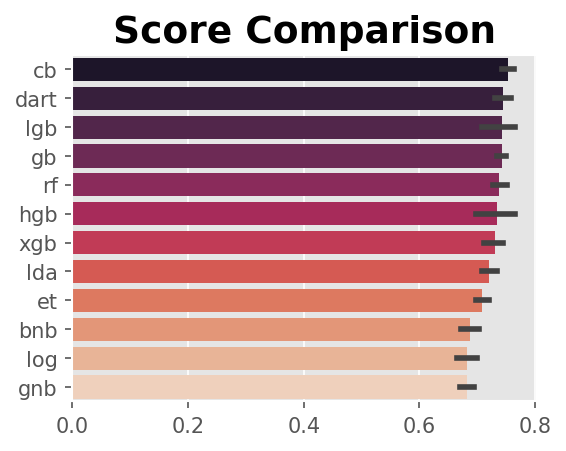

In [46]:
plt.figure(figsize = (4, 3), dpi = 150)
sns.barplot(data = score_list.reindex((-1 * score_list).mean().sort_values().index, axis = 1), orient = 'h', palette='rocket')
plt.title('Score Comparison', weight = 'bold', size = 18)
plt.show()

As we can see, the `CatBoostClassifier`, `LGBMClassifier(boosting_type="dart")` and `LGBMClassifier` are the top 3 models based on the score

<a id='voting'></a>
# <span style='color:#0d9dd6;'>|</span> Voting
So let´s try to build a `VotingClassifier` for our final model, based on the three best models. 

In [30]:
lgb_model = LGBMClassifier(random_state = seed, verbose = -1)
dart_model = LGBMClassifier(random_state = seed, boosting_type = 'dart', verbose = -1)
cb_model = CatBoostClassifier(random_state = seed, verbose = 0)
voting = VotingClassifier(estimators=[
    ('lgb', lgb_model),
    ('dart', dart_model),
    ('cb', cb_model)
], voting='soft')

In [31]:
_ = cross_validation_score(estimator=voting, cv=skf, label='voter')

Val Score: 0.75667 ± 0.02061 | Train Score: 0.97889 ± 0.00297 | voter


<a id='final_model'></a>
# <span style='color:#0d9dd6;'>|</span> Final Model
After we trained our voting model with cross validation, it´s time to finally train our final model on the whole dataset. 

In [32]:
# Separate target from data
y = data['Risk']
X = data.drop(columns=['Risk'])

In [33]:
y = encoder.transform(y)

In [34]:
X = pd.get_dummies(X)

In [35]:
voting.fit(X,y)

VotingClassifier(estimators=[('lgb',
                              LGBMClassifier(random_state=1702, verbose=-1)),
                             ('dart',
                              LGBMClassifier(boosting_type='dart',
                                             random_state=1702, verbose=-1)),
                             ('cb',
                              <catboost.core.CatBoostClassifier object at 0x787f2b1e0fd0>)],
                 voting='soft')

<a id='prediction_on_evaluation_set'></a>
# <span style='color:#0d9dd6;'>|</span> Prediction on evaluation set
Before we trained our models I separated a small subset from the data. I will use the final model to run a prediction on that data. 

In [36]:
eval_set = evaluation_set
eval_y = eval_set['Risk']
eval_X = eval_set.drop(columns=['Risk'])
eval_y = encoder.transform(eval_y)
eval_X = pd.get_dummies(eval_X)

In [37]:
eval_predictions = voting.predict(eval_X)

In [38]:
# Inverse the target back to good and bad
inv_eval_y = encoder.inverse_transform(eval_y)
inv_eval_predictions = encoder.inverse_transform(eval_predictions)

In [39]:
print(f'Accuracy Score: {accuracy_score(inv_eval_y, inv_eval_predictions)}')

Accuracy Score: 0.76


In [40]:
print(classification_report(inv_eval_y, inv_eval_predictions))

              precision    recall  f1-score   support

         bad       0.67      0.45      0.54        31
        good       0.78      0.90      0.84        69

    accuracy                           0.76       100
   macro avg       0.73      0.68      0.69       100
weighted avg       0.75      0.76      0.75       100



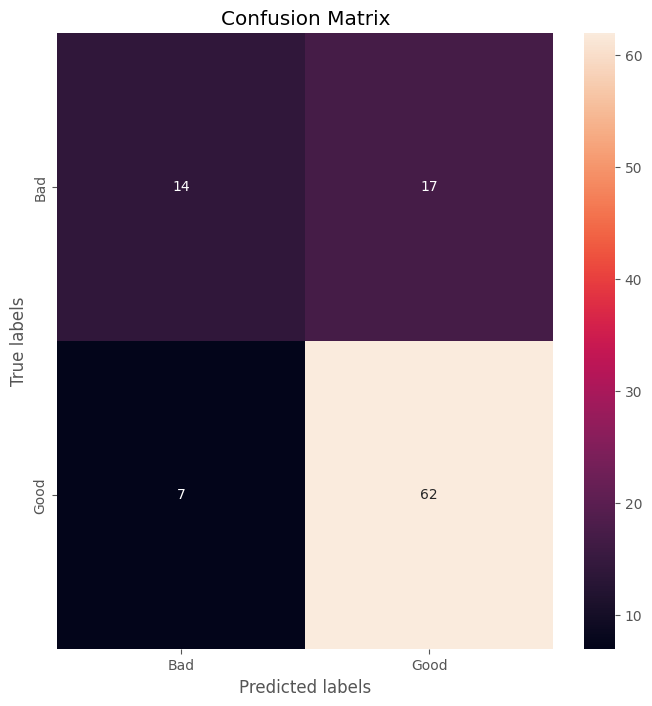

In [41]:
cm = confusion_matrix(inv_eval_y, inv_eval_predictions)
cm_matrix = pd.DataFrame(data=cm, index=['Actual: bad', 'Actual: good'], columns=['Predicted: bad', 'Predicted: good'])
plt.figure(figsize=(8,8))
sns.heatmap(cm_matrix, annot=True, cmap='rocket', fmt='g', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show();

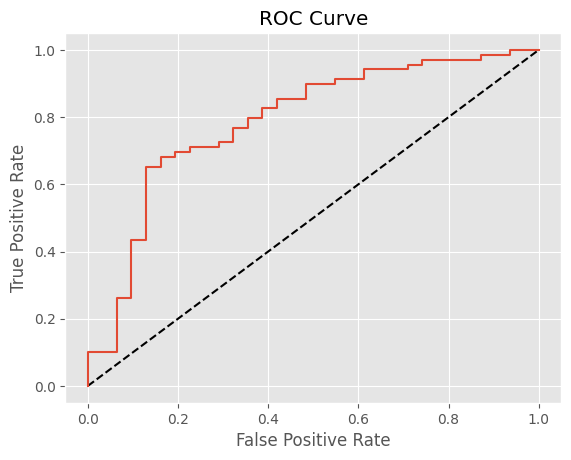

In [42]:
pred_eval_proba = voting.predict_proba(eval_X)[:,1]
fpr, tpr, thresholds = roc_curve(eval_y, pred_eval_proba)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show();

The model achieves an accuracy of 76% on the evaluation set. This is not bad in the first step. We have not done any feature engineering. We did not scale the data and we did not take care of the outliers. We also ignored the problem of the unbalanced dataset. So there are still a few tasks that could be done to make the final model even better. 